# Clustering Routine

This Jupyter Notebook can be ran after the initial crawling with the *crawl.py* python script to categorize a big number of news articles by their topics. The duration of the Jupyter Notebook processing time may vary depending on your dataset size. You can estimate at least a few hours for datasets bigger than 50 000 articles.

# Routine Of The Jupyter Notebook

This algorithm can be structured into the following main components:

1. Load crawled dataset from the folder *./crawl_json/*.
2. Preprocessing.
3. Visualize the data with wordclouds.
4. LDA Clustering. Find the optimal amount of clusters with the coherence score.
5. Visualize the optimal topic clusters with LDAvis.
6. Sort all documents into a directory *./clustered_json/* to represent their cluster topics.


# Open Data From JSON
First we have to load our previously cralwed dataset into memory.

In [1]:
import pandas as pd
import os
import glob

In [2]:
path = 'crawl_json/'
frames = []
for filename in glob.glob(os.path.join(path, '*.json')): #only process .JSON files in folder.      
    with open(filename, encoding='utf-8', mode='r') as currentFile:
        frames.append(pd.read_json(currentFile, orient='index'))

df = pd.concat(frames)
df.drop(['authors', 'image_url', 'localpath', 'title_page', 'title_rss'], axis = 1, inplace = True)
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...


# Amount of articles that will be processed:

In [3]:
amount_of_articles = len(df["maintext"])
print(f"Amount of articles: {amount_of_articles}")

Amount of articles: 268122


# Preprocessing 

We will now continue with preparing the data for the actual clustering. Therefore we are lemmatizing all strings and removing all words that aren't nouns.

In [4]:
import re

In [5]:
df['id'] = df.index
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2


In [6]:
# Remove punctuation
df['maintext_prepro'] = \
df['maintext'].map(lambda x: re.sub('[,\.!?]', '', x))
# To lowercase
df['maintext_prepro'] = \
df['maintext_prepro'].map(lambda x: x.lower())

In [7]:
import nltk
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
is_noun = lambda pos: pos[:2] == 'NN'
nouns = []

stemmer = WordNetLemmatizer()

estimated_minutes = amount_of_articles * 0.000217

print(f'Tokenizing all articles. This may take a while. (Estimate: ~{ round(estimated_minutes, 2) } minutes)')
df['tokenized_words'] = df['maintext'].apply(nltk.word_tokenize)
print("Finished tokenizing all articles. Continue with lemmatization & noun extraction.")


Tokenizing all articles. This may take a while. (Estimate: ~58.18 minutes)
Finished tokenizing all articles. Continue with lemmatization & noun extraction.


In [9]:
print("Lemmatization & noun extraction is running...")
for element in tqdm(df["tokenized_words"]):
	nouns.append(" ".join([stemmer.lemmatize(word) for (word, pos) in nltk.pos_tag(element) if is_noun(pos) and len(word) > 2]))    # joined as a single string per article

print("Finished lemmatization & noun extraction.")
df["maintext_nouns"] = nouns

Lemmatization & noun extraction is running...


100%|██████████| 268122/268122 [4:49:03<00:00, 15.46it/s]


Finished lemmatization & noun extraction.


In [10]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...


# Word Cloud

The following word clouds will give you a general idea about how each step in preprocessing improves the quality of the dataset for our use case. The bigger a word is shown, the more frequent is its existence in our dataset. 

In [11]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1000, height=400, background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Word Cloud All Words

This word cloud includes all words of the articles without major filtering.

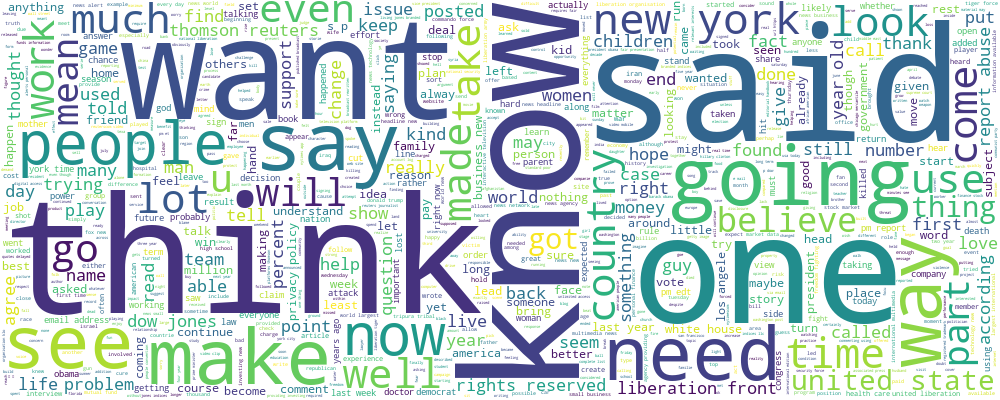

In [12]:
all_articles_string = ','.join(list(df['maintext_prepro'].values))
wordcloud.generate(all_articles_string)

wordcloud.to_image()

# Word Cloud Only Nouns

This word cloud shows you only the nouns of the acticles.

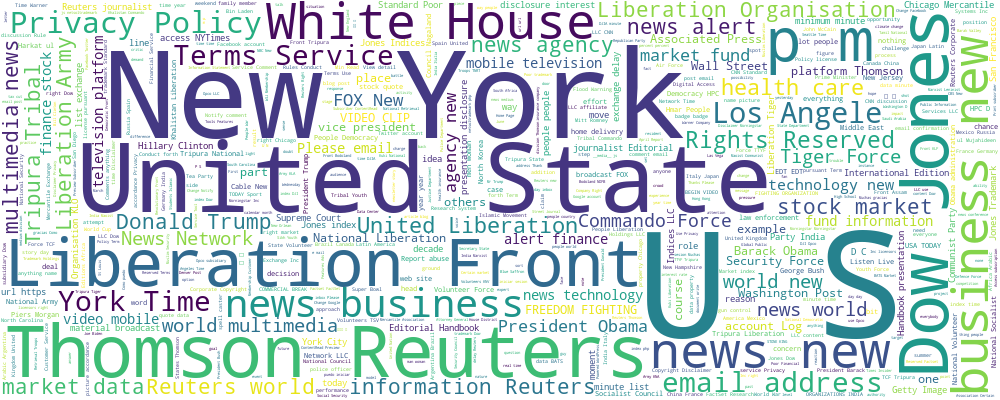

In [13]:
all_articles_nouns = ','.join(list(df['maintext_nouns'].values))
wordcloud.generate(all_articles_nouns)

wordcloud.to_image()

# Prepare data for LDA analysis

We will continue preparing our data for the LDA clustering by removing predefined stopwords (extended by *./stopwords.json*) and filtering out unwanted characters.

In [14]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import json

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
stop_words = stopwords.words('english')

with open("stopwords.json") as jsonFile:
    jsonStopwords = json.load(jsonFile)

#extend stopwords if desired
stop_words.extend(jsonStopwords)  


In [16]:
#Tokenize Text
def sentence_to_words(sentences):
    for sent in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(sent, deacc=True))

In [17]:
#Remove Stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if (word not in stop_words)] for doc in texts]    #filtering

In [18]:
#Remove non alphanumeric words
def remove_non_alphanumeric(texts):
    return [[word for word in list if word.isalnum()] for list in texts]

In [19]:
#remove words that are not written in ASCII
def remove_non_ASCII(lists):
    for list in lists:
        for i, string in enumerate(list):
            if string.isascii():
                continue
            else:
                list.pop(i)
    return lists

In [20]:
maintext_data = df["maintext_nouns"].values.tolist()
df["maintext_ready"] = list(sentence_to_words(maintext_data))

maintext_ready = remove_stopwords(df["maintext_ready"].tolist())
maintext_ready = remove_non_ASCII(maintext_ready)
df["maintext_ready"]  = maintext_ready

In [21]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, talk,..."
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...,"[brands, publisher, esports, sponsorship, oppo..."
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[global, public, square, show, fareed, take, g..."


# Wordcloud of the ready-to-cluster articles

This is the word cloud of the dataset which we will actually apply out LDA clustering on.

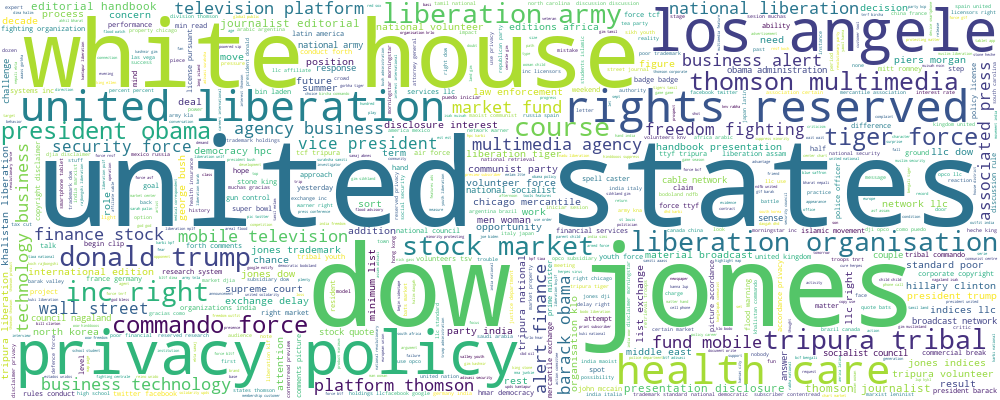

In [22]:
ready_wordlist = []
for element in df["maintext_ready"]:
    ready_wordlist.append(','.join(list(element)))

all_articles_ready = ','.join(ready_wordlist)
wordcloud.generate(all_articles_ready)

wordcloud.to_image()

# Create the Corpus

Creating a corpus is needed to have data that is understandable to gensim. This will be given to the LDA algorithm to perform the clustering.

In [23]:
import gensim.corpora as corpora

In [24]:
data = df["maintext_ready"].tolist()

word_dictionary = corpora.Dictionary(data)

corpus = [word_dictionary.doc2bow(text) for text in data]   #create the corpus

df["corpus"] = corpus

In [25]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, talk,...","[(0, 2), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2..."
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...,"[brands, publisher, esports, sponsorship, oppo...","[(24, 1), (25, 1), (26, 1), (27, 7), (28, 1), ..."
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[global, public, square, show, fareed, take, g...","[(3, 1), (24, 5), (54, 1), (82, 1), (95, 1), (..."


# Build a LDA model & calculate Coherence Score

The following code is going through a prefined range of topic amounts to check which clustering approach suits the dataset best. Each iteration inlcludes the clustering of all articles and the calculation of the coherence score. Once a certain coherence is reached, the algorithm continues with taking the best possible clusters.
We implement this break within the algorithm to avoid unneccasary splitting of clusters.

In [26]:
from pprint import pprint   #pretty printing
from gensim.models import CoherenceModel

In [27]:
topic_amount_start = 10     #specify where to start generating clusters
topic_amount_end = 50      #specify the maximum amount of clusters (will need more RAM during calculations)
iteration_interval = 1      #the interval in which coherences and lda models should be calculated (for example: iteration_interval = 5 => 10,15,20,25,... clusters). For best results choose 1 (but it will take longer then)
desired_coherence = 0.6     #the minimum coherence. if set too high, the algorithm will continue with the clusters with highest coherence score between topic_amount_start and topic_amound_end

The following snipped is responsible for the actual LDA clustering. It will determine the coherence score each iteration and choose the best possible clusters based on the coherence score.
If `desired_coherence` is met, the algorithm will break to avoid unneccasary high amounts of clusters.

In [28]:
amount_of_topics = 0
best_coherence = 0
best_lda_model = 0

coherences = []
lda_models = []

print(f"Calculating the optimal amount of clusters inbetween {topic_amount_start} and {topic_amount_end}.")

#Find the best possible coherence value inbetween the given min and max amount of articles. Continue with the best lda model found.
for amount_of_topics in range(topic_amount_start, topic_amount_end, iteration_interval):   
    lda_model = gensim.models.LdaMulticore(corpus = corpus, id2word = word_dictionary, num_topics = amount_of_topics, alpha=0.1, eta=0.01)   #build the LDA model

    cm = CoherenceModel(model=lda_model, texts=df["maintext_ready"].tolist(), dictionary=word_dictionary, coherence='c_v')     #calculate coherence
    coherence = cm.get_coherence()
    print(f"Coherence with {amount_of_topics} topics: ", coherence)

    coherences.append(coherence)
    lda_models.append(lda_model)

    if (coherence > desired_coherence):
        best_coherence = coherence
        best_lda_model = lda_model
        print("Reached the desired coherence score!")
        break;      # desired coherence score met



Calculating the optimal amount of clusters inbetween 10 and 50.
Coherence with 10 topics:  0.4902224303536463
Coherence with 11 topics:  0.4697026394616417
Coherence with 12 topics:  0.5382360921482457
Coherence with 13 topics:  0.511987928837334
Coherence with 14 topics:  0.5257351488370676
Coherence with 15 topics:  0.5304986783478514
Coherence with 16 topics:  0.5011884577059378
Coherence with 17 topics:  0.4719685929266942
Coherence with 18 topics:  0.44973438732461063
Coherence with 19 topics:  0.5656416193737789
Coherence with 20 topics:  0.5041741204563001
Coherence with 21 topics:  0.48170852127408637
Coherence with 22 topics:  0.5109810356104229
Coherence with 23 topics:  0.5162895096080363
Coherence with 24 topics:  0.460223149026956
Coherence with 25 topics:  0.5069205114266808
Coherence with 26 topics:  0.4490677225101003
Coherence with 27 topics:  0.4970608370150742
Coherence with 28 topics:  0.4805840052719805
Coherence with 29 topics:  0.5056562846490728
Coherence with 3

In [29]:
#Determine the best coherence of all if the desired_coherence wasnt matched
if (best_coherence == 0):
    print("Desired coherence not reached. Please adjust the desired_coherence paramter to a more realistic value. Continuing with the best possible coherence.")
    max_coherence = max(coherences)
    max_index = coherences.index(max_coherence)
    print(max_index)
    best_lda_model = lda_models[max_index]

amount_of_topics = len(best_lda_model.get_topics())
print("Best coherence: " + str(max_coherence) + ", Amount of clusters: " + str(amount_of_topics))

Desired coherence not reached. Please adjust the desired_coherence paramter to a more realistic value. Continuing with the best possible coherence.
9
Best coherence: 0.5656416193737789, Amount of clusters: 19


In [30]:
print(len(lda_model[corpus]))

268122


In [31]:
import matplotlib.pyplot as plt

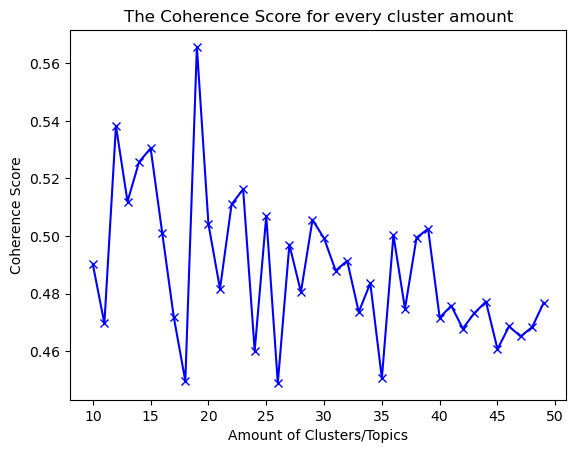

In [32]:
# A graph about how the coherence changes depending on the amount of clusters
plt.plot(range(topic_amount_start, topic_amount_end, iteration_interval), coherences, 'bx-')
plt.xlabel('Amount of Clusters/Topics')
plt.ylabel('Coherence Score')
plt.title('The Coherence Score for every cluster amount')
plt.show()

# Displaying the LDA model

This is the built LDA model. The first number represents the cluster ID. The other part shows you the propablity of words in the specific topic.

In [33]:
pprint(best_lda_model.print_topics())
articles_lda = best_lda_model[corpus]

[(0,
  '0.005*"book" + 0.004*"water" + 0.004*"city" + 0.004*"show" + 0.003*"iran" + '
  '0.003*"war" + 0.003*"ufc" + 0.003*"film" + 0.003*"work" + 0.002*"music"'),
 (1,
  '0.007*"percent" + 0.007*"china" + 0.004*"united" + 0.004*"business" + '
  '0.004*"market" + 0.004*"mexico" + 0.003*"food" + 0.003*"thomson" + '
  '0.003*"policy" + 0.003*"japan"'),
 (2,
  '0.011*"school" + 0.007*"student" + 0.006*"government" + 0.005*"child" + '
  '0.005*"health" + 0.004*"war" + 0.004*"president" + 0.004*"official" + '
  '0.003*"business" + 0.003*"program"'),
 (3,
  '0.023*"force" + 0.021*"liberation" + 0.017*"tripura" + 0.015*"national" + '
  '0.010*"united" + 0.009*"india" + 0.008*"army" + 0.006*"tribal" + '
  '0.005*"muslim" + 0.005*"khalistan"'),
 (4,
  '0.014*"obama" + 0.012*"president" + 0.006*"party" + 0.006*"campaign" + '
  '0.006*"house" + 0.005*"bush" + 0.005*"clinton" + 0.004*"candidate" + '
  '0.004*"mccain" + 0.004*"election"'),
 (5,
  '0.006*"president" + 0.004*"market" + 0.004*"loan" +

# Visualize the LDA model

This visualization is interactable and helps you identifying the quality of the LDA clustering by hand.

In [34]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()

In [35]:
LDAvis_data_filepath = os.path.join('./lda_results/ldavis_data_'+str(amount_of_topics)+'topics')

LDAvis_prepared = pyLDAvis.gensim_models.prepare(best_lda_model, corpus, word_dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

#load pre-prepared pyLDAvis data
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_data = pickle.load(f)
pyLDAvis.save_html(LDAvis_data, './lda_results/ldavis_data_'+ str(amount_of_topics) +'topics.html')
LDAvis_data #show the data

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.003022  0.071006       1        1  12.318235
15     0.005149  0.085176       2        1  11.521061
0     -0.034610  0.023981       3        1   9.685765
2      0.021713  0.027091       4        1   6.840111
3      0.190020 -0.002363       5        1   5.939702
7     -0.109406  0.003284       6        1   5.667164
16    -0.090894  0.010563       7        1   5.526232
13     0.004599  0.002282       8        1   5.129131
9      0.008266  0.019819       9        1   4.743074
14    -0.006329  0.003823      10        1   4.408006
10     0.012635 -0.002229      11        1   4.306169
5      0.001395 -0.005224      12        1   4.185055
6     -0.012410  0.042163      13        1   3.870838
18    -0.022193  0.007991      14        1   3.310048
8     -0.037881 -0.134596      15        1   2.928389
1      0.013008 -0.019321      16        1   2.743904
17     0.023364 -0.058997      17        1   2.544755
12     0.023633 -0.060493      18        1   2.438757
11     0.006917 -0.013956      19        1   1.893604, topic_info=             Term           Freq          Total Category  logprob  loglift
812    liberation  129189.000000  129189.000000  Default  30.0000  30.0000
1264        force  203474.000000  203474.000000  Default  29.0000  29.0000
101         jones   98358.000000   98358.000000  Default  28.0000  28.0000
65039     tripura  104397.000000  104397.000000  Default  27.0000  27.0000
60            dow   71039.000000   71039.000000  Default  26.0000  26.0000
...           ...            ...            ...      ...      ...      ...
1711          war    3421.172430  155642.517785  Topic19  -6.1785   0.1491
397        market    3096.849124  155918.284505  Topic19  -6.2781   0.0477
1185        court    2918.671587  103786.366850  Topic19  -6.3373   0.3955
2692    statement    2739.591512   97501.569514  Topic19  -6.4006   0.3946
303           man    2742.690759  180056.637458  Topic19  -6.3995  -0.2176

[2123 rows x 6 columns], token_table=        Topic      Freq       Term
term                              
115003      2  0.012015  abbeville
115003      4  0.012015  abbeville
115003      5  0.012015  abbeville
115003     10  0.024029  abbeville
115003     11  0.012015  abbeville
...       ...       ...        ...
79608      15  0.005894        ไหล
79608      16  0.005894        ไหล
79608      17  0.017682        ไหล
79608      18  0.008841        ไหล
79608      19  0.008841        ไหล

[19973 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 16, 1, 3, 4, 8, 17, 14, 10, 15, 11, 6, 7, 19, 9, 2, 18, 13, 12])

# Store Cluster IDs to dataframe

To be able to correctly sort all articles into a floder hierachy wee need to store each articles cluster id into the dataframe.

In [36]:
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric

topics = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]

lda_topics = best_lda_model.show_topics(num_words=5)
for topic in lda_topics:
    print(topic)
    topics.append(preprocess_string(topic[1], filters))

(1, '0.007*"percent" + 0.007*"china" + 0.004*"united" + 0.004*"business" + 0.004*"market"')
(3, '0.023*"force" + 0.021*"liberation" + 0.017*"tripura" + 0.015*"national" + 0.010*"united"')
(9, '0.004*"group" + 0.004*"subscriber" + 0.003*"google" + 0.003*"apple" + 0.003*"child"')
(18, '0.005*"woman" + 0.004*"show" + 0.004*"man" + 0.004*"house" + 0.004*"police"')
(0, '0.005*"book" + 0.004*"water" + 0.004*"city" + 0.004*"show" + 0.003*"iran"')
(10, '0.006*"house" + 0.006*"police" + 0.006*"court" + 0.006*"district" + 0.004*"officer"')
(15, '0.009*"child" + 0.007*"god" + 0.007*"woman" + 0.005*"man" + 0.005*"herpes"')
(5, '0.006*"president" + 0.004*"market" + 0.004*"loan" + 0.004*"car" + 0.004*"government"')
(14, '0.010*"school" + 0.006*"city" + 0.006*"badge" + 0.004*"washington" + 0.003*"president"')
(6, '0.014*"trump" + 0.014*"president" + 0.005*"obama" + 0.005*"house" + 0.004*"california"')


C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
topic_list = []
topic_percentage_list = []
topic_keywords_list = []

for row in tqdm(articles_lda):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    topic_num = row[0][0]
    prop_topic = row[0][1]

    wp = best_lda_model.show_topic(topic_num)
    topic_keywords = ", ".join([word for word, prop in wp])
    topic_list.append(int(topic_num))
    topic_percentage_list.append(round(prop_topic,5))
    topic_keywords_list.append(topic_keywords)


df["LDA_ID"] = topic_list    ##the id of the topic
df["LDA_topic_percentage"] = topic_percentage_list  #how well the topic fits to this specifc article
df["LDA_topic_keywords"] = topic_keywords_list  #the dominant keywords for the topic

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 268122/268122 [4:58:31<00:00, 14.97it/s]


In [38]:
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus,LDA_ID,LDA_topic_percentage,LDA_topic_keywords
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, talk,...","[(0, 2), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2...",2,0.81394,"school, student, government, child, health, wa..."
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...,"[brands, publisher, esports, sponsorship, oppo...","[(24, 1), (25, 1), (26, 1), (27, 7), (28, 1), ...",9,0.77848,"group, subscriber, google, apple, child, compu..."
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[global, public, square, show, fareed, take, g...","[(3, 1), (24, 5), (54, 1), (82, 1), (95, 1), (...",9,0.65278,"group, subscriber, google, apple, child, compu..."


# Output LDA clustering to json files


In [39]:
df = df.drop(columns=["maintext_prepro", "tokenized_articles", "maintext_nouns", "corpus", "id"], errors='ignore')   #drop unwanted attributes that should not be output into the json files.

filtered_maintext = [ " ".join(row["maintext_ready"]) for index, row in df.iterrows() ]   

df["filtered_maintext"] = filtered_maintext

df = df.drop(columns=["maintext_ready", "tokenized_words"])

df.head()

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,LDA_ID,LDA_topic_percentage,LDA_topic_keywords,filtered_maintext
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,2,0.81394,"school, student, government, child, health, wa...",neighbors forums general discussion talk denve...
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,9,0.77848,"group, subscriber, google, apple, child, compu...",brands publisher esports sponsorship opportuni...
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,9,0.65278,"group, subscriber, google, apple, child, compu...",global public square show fareed take gps durg...
3,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:08:18","Skip to main content Published: Jan 23, 2019 B...",en,jobs.washingtonpost.com,"Skip to main content Published: Jan 23, 2019By...",How Much Salary Negotiation Is Too Much?,https://jobs.washingtonpost.com/article/how-mu...,2,0.71705,"school, student, government, child, health, wa...",skip arden davidson salary balancing act price...
4,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:30",One of artist Shepard Fairey's next projects c...,en,latimesblogs.latimes.com,One of artist Shepard Fairey's next projects ...,Shepard Fairey puts services up for auction | ...,https://latimesblogs.latimes.com/culturemonste...,0,0.83470,"book, water, city, show, iran, war, ufc, film,...",artist shepard fairey project portrait los ang...


# Generating folder structure

The following code creates the desired folder hierarchy and names each cluster after the top 3 dominant words in each one. Within each cluster/folder we are subclustering all articles by their release date.
The output json file has the format *year-month.json*. 

In [40]:
import ujson

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
df.reset_index(drop=True,inplace=True)

for cluster_id, data in df.groupby(df.LDA_ID):
    item = data.LDA_topic_keywords.iloc[0].split(",")
    with open(f'./lda_clustered_json/cluster_{cluster_id}-{item[0]}_{item[1]}_{item[2]}.json', 'w', encoding='utf-8') as f:
        f.write(ujson.dumps(data.to_dict('index'), indent=4, ensure_ascii=False, escape_forward_slashes=False))

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
